In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from os import listdir
from os.path import isfile, join
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
listdir()
#get files
list_files = [file for file in listdir() if ".csv" in file]
list_files

['Medicare Hospital Spending by Claim 2017.csv',
 'Medicare Hospital Spending by Claim 2016.csv',
 'Hospital General Information 2016.csv',
 'Hospital General Information 2017.csv']

In [2]:
#update files
hosp_genfiles = []
spending_claim_files = []
for file in list_files:
    #get on only general info files
    if "General" in file:
        #store in hosp gen files
        hosp_genfiles.append(file)
    else:
        spending_claim_files.append(file)
#order list of files by inceasing years
hosp_genfiles = sorted(hosp_genfiles,key = lambda x: x.partition('Information ')[2].partition('.')[0] )
hosp_genfiles
spending_claim_files = sorted(spending_claim_files, key = lambda x: x.partition('Claim ')[2].partition('.')[0])
spending_claim_files

#update hosp_genfiles
updated_hosp_frames = []
for i in range(0,2):
    #go through hosp_gen_files
    frame = pd.read_csv(hosp_genfiles[i],encoding = "ISO-8859-1")
    #get nonfootnote columns
    not_foot_note_columns = [not_footnote_column for not_footnote_column in frame.columns if "footnote" not in not_footnote_column]
    #update frame
    frame = frame[not_foot_note_columns]
    #create year column
    frame['year'] = pd.Series(data = np.repeat(i+2016, frame.shape[0]))
    #melt the frame
    melted_frame = pd.melt(frame=frame,)
    #add to updates_hosp_frames
    updated_hosp_frames.append(frame)

combined_hosp_frames = pd.merge(updated_hosp_frames[0],updated_hosp_frames[1],how="outer", on=['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Hospital Type', 'Hospital Ownership',
       'Emergency Services', 'Meets criteria for meaningful use of EHRs',
       'Hospital overall rating', 'Mortality national comparison',
       'Safety of care national comparison', 'Readmission national comparison',
       'Patient experience national comparison',
       'Effectiveness of care national comparison',
       'Timeliness of care national comparison',
       'Efficient use of medical imaging national comparison','year'])
print(combined_hosp_frames.shape)
print(updated_hosp_frames[0].shape)
#get only hospitals present in both years
index_2016 = combined_hosp_frames['year'] == 2016



(10131, 21)
(4797, 21)


In [3]:
#get only hospitals present in both years
index_2016 = combined_hosp_frames['year'] == 2016
index_2017 = combined_hosp_frames['year'] == 2017
providers_2016 = combined_hosp_frames['Provider ID'][index_2016]
providers_2017 = combined_hosp_frames['Provider ID'][index_2017]
providers_both_years = list(set(providers_2016).intersection(set(providers_2017)))
index_both_years = combined_hosp_frames['Provider ID'].isin(providers_both_years)
#created combined hosp_both years
combined_hosp_frames_both_years = combined_hosp_frames[index_both_years]
#make columns lowercase
lower_case_cols = [col.lower() for col in combined_hosp_frames_both_years.columns]
combined_hosp_frames_both_years.columns = lower_case_cols
print(combined_hosp_frames_both_years['year'].value_counts())

2017    4738
2016    4738
Name: year, dtype: int64


In [4]:
updated_spending_claims = []
for i in range(0,2):
    #go through hosp_gen_files
    frame = pd.read_csv(spending_claim_files[i],encoding = "ISO-8859-1")
    #lower case the column names
    columns_lower_case = [col.lower() for col in frame.columns]
    frame.columns = columns_lower_case
    #get correct columns
    columns_to_use = [column for column in frame.columns if 'percent' not in column.partition("_")[0] and "start" 
                  not in column.partition("_")[0] and "end" not in column.partition("_")[0]]
    #subset frame with correct columns
    frame = frame[columns_to_use]
    #create year column
    frame['year'] = pd.Series(data = np.repeat(i+2016, frame.shape[0]))
    #add to updates_hosp_frames
    updated_spending_claims.append(frame)

In [5]:
print(updated_spending_claims[0].columns)
print(updated_spending_claims[1].columns)
#colum names don't match, but the values represent the same thigs
#set col names from one frame equal to another
updated_spending_claims[1].columns = updated_spending_claims[0].columns
combined_spending_claims = pd.merge(updated_spending_claims[0],updated_spending_claims[1],how="outer",
                                   on= list(updated_spending_claims[0].columns))
combined_spending_claims['claim_type'].value_counts()
#only 6729 have calime type total
#subset only claims with total
index_total = combined_spending_claims['claim_type'] == 'Total'
combined_spending_claims_total = combined_spending_claims[index_total]
combined_spending_claims_total['year'].value_counts()

Index(['hospital_name', 'provider_id', 'state', 'period', 'claim_type',
       'avg_spending_per_episode_hospital', 'avg_spending_per_episode_state',
       'avg_spending_per_episode_nation', 'year'],
      dtype='object')
Index(['hospital_name', 'provider_id', 'state', 'period', 'claim_type',
       'avg_spndg_per_ep_hospital', 'avg_spndg_per_ep_state',
       'avg_spndg_per_ep_national', 'year'],
      dtype='object')


2016    3148
2017    3131
Name: year, dtype: int64

In [6]:
#merger combined_spending_claims_total and combined_hosp_frames_both_years
#but first, correct the provider is column
combined_hosp_frames_both_years.rename(columns={'provider id':'provider_id'},inplace=True)
#complete the merge
combined_spending_and_hosp_related = pd.merge(combined_hosp_frames_both_years,combined_spending_claims_total,
                                              how='outer',on=['provider_id','year','state',])
max(combined_spending_and_hosp_related['provider_id'].value_counts())
#yes, only duplicates by year!

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


2

In [7]:
combined_spending_and_hosp_related.head()

,provider_id,hospital name,address,city,state,zip code,county name,phone number,hospital type,hospital ownership,emergency services,meets criteria for meaningful use of ehrs,hospital overall rating,mortality national comparison,safety of care national comparison,readmission national comparison,patient experience national comparison,effectiveness of care national comparison,timeliness of care national comparison,efficient use of medical imaging national comparison,year,hospital_name,period,claim_type,avg_spending_per_episode_hospital,avg_spending_per_episode_state,avg_spending_per_episode_nation
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,HOUSTON,3.347939e+09,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,Same as the national average,Above the national average,Below the national average,Below the national average,Same as the national average,Same as the national average,Same as the national average,2016,SOUTHEAST ALABAMA MEDICAL CENTER,Complete Episode,Total,20711.0,19139.0,20302.0
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957.0,MARSHALL,2.565938e+09,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,Below the national average,Same as the national average,Above the national average,Same as the national average,Same as the national average,Above the national average,Below the national average,2016,MARSHALL MEDICAL CENTERS,Complete Episode,Total,16849.0,19139.0,20302.0
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631.0,LAUDERDALE,2.567688e+09,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,Below the national average,Same as the national average,Below the national average,Below the national average,Same as the national average,Above the national average,Below the national average,2016,ELIZA COFFEE MEMORIAL HOSPITAL,Complete Episode,Total,19553.0,19139.0,20302.0
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467.0,COVINGTON,3.344934e+09,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2,Below the national average,Not Available,Below the national average,Same as the national average,Below the national average,Above the national average,Not Available,2016,MIZELL MEMORIAL HOSPITAL,Complete Episode,Total,15899.0,19139.0,20302.0
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049.0,CRENSHAW,3.343353e+09,Acute Care Hospitals,Proprietary,Yes,Y,4,Not Available,Not Available,Above the national average,Not Available,Same as the national average,Above the national average,Not Available,2016,CRENSHAW COMMUNITY HOSPITAL,Complete Episode,Total,12254.0,19139.0,20302.0


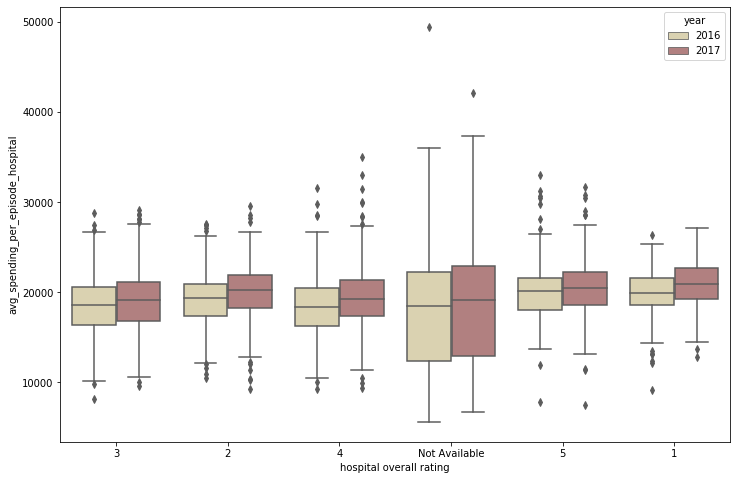

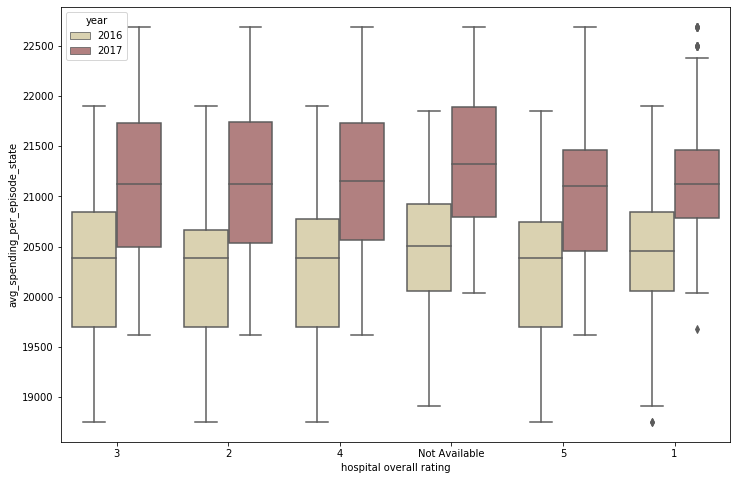

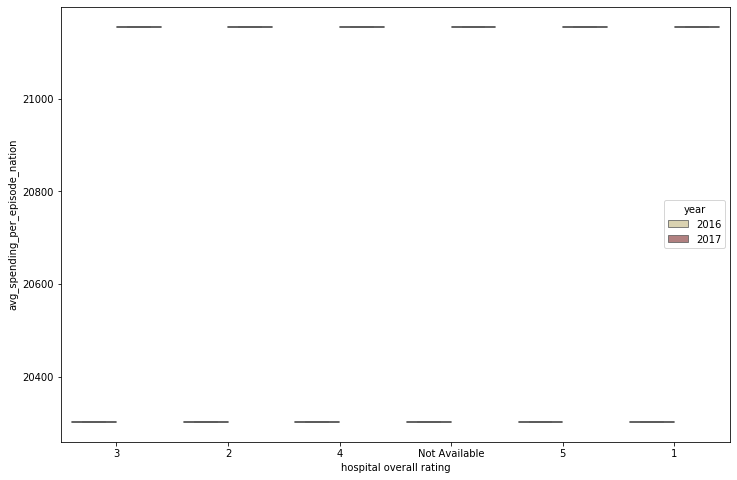

In [8]:
#examine spending per variables
#x is overall hos rating, y is vairable, contoured by year
variables_to_examine = ['avg_spending_per_episode_hospital','avg_spending_per_episode_state',
                       'avg_spending_per_episode_nation']
for var in variables_to_examine:
    plt.figure(figsize=(12,8))
    ax = sns.boxplot(x="hospital overall rating", y=var, 
                     hue="year",data=combined_spending_and_hosp_related, palette="pink_r")
    plt.show()
#nation is only one of two values

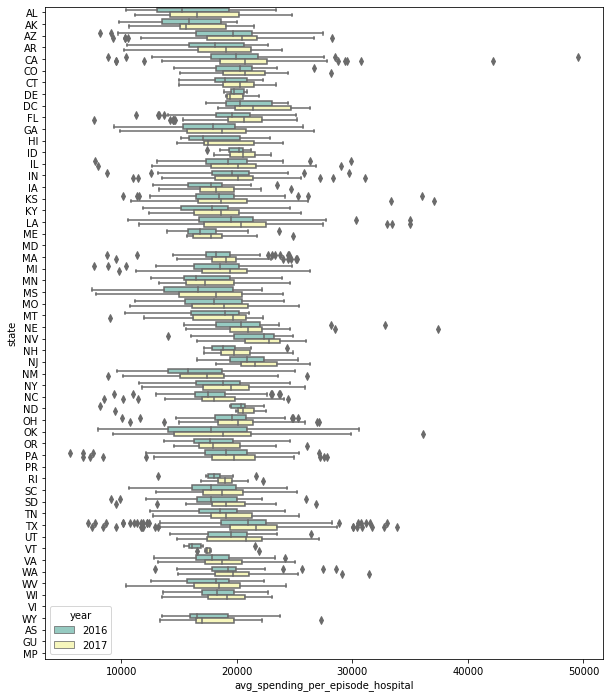

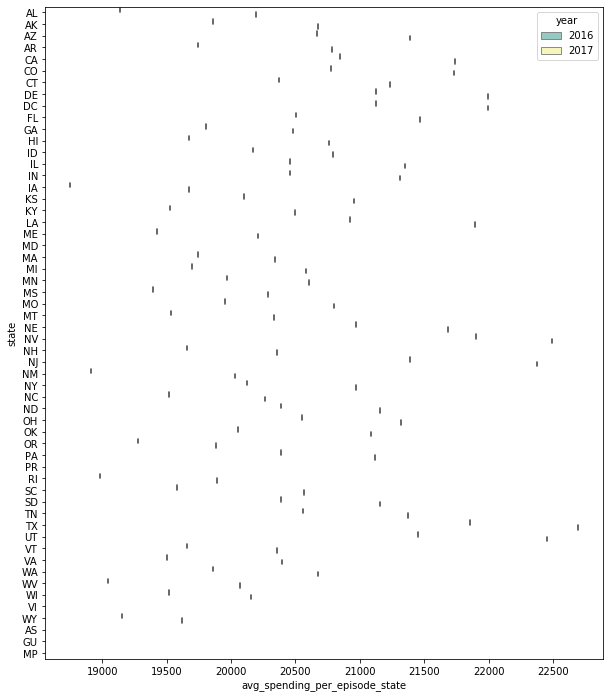

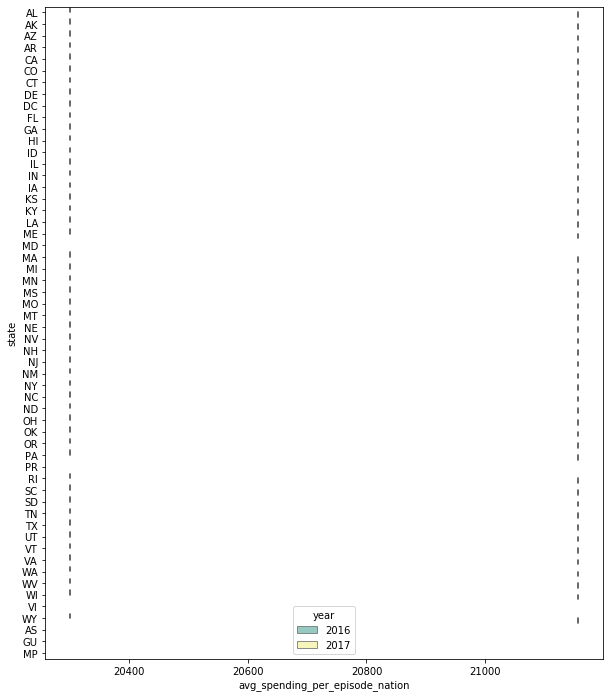

In [343]:
#now do it for each state
for var in variables_to_examine:
    plt.figure(figsize=(10,12))
    ax = sns.boxplot(y="state", x=var, 
                     hue="year",data=combined_spending_and_hosp_related, palette="Set3")
    plt.show()
#again nation is only one of two values
#avearge spending per state by state is are only single values, there are no distrbutions
#it may be better to show average_spending per state as a whole, and compare between the two years

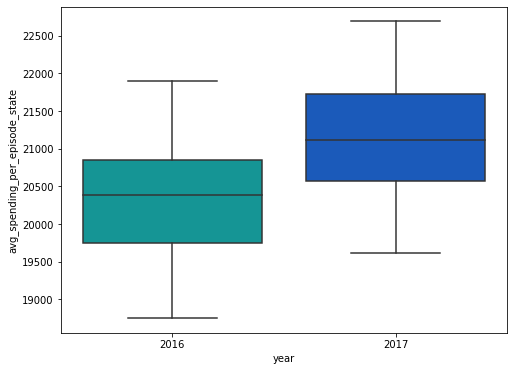

In [9]:
#get summay statistic by state
combined_spending_and_hosp_related.groupby(['state','year']).describe()
#examing by state shows that avg spending per hopsital increased
#average for the nation, increased 20302 to 21155
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="year", y='avg_spending_per_episode_state', 
                 data=combined_spending_and_hosp_related, palette="winter_r")


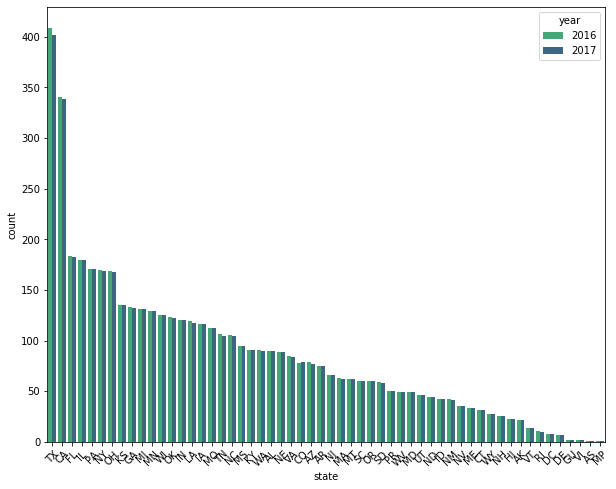

In [10]:
#List the top five states by maximum number of hospitals in the country. 
#What percent of all hospitals exist in these states?
plt.figure(figsize=(10,8))
ax = sns.countplot(x="state", hue="year", data=combined_spending_and_hosp_related,palette="viridis_r",
                  order = combined_spending_and_hosp_related['state'].value_counts().index)
plt.xticks(rotation=45)
plt.show()
#the tope five are TX, CA, FL, IL, PA

In [15]:
#find min num domains to get a hospital rating
#for those with a rating, how many did they report
no_rating_idx = combined_spending_and_hosp_related['hospital overall rating'] != 'Not Available'
no_rating_hospitals = combined_spending_and_hosp_related[no_rating_idx]
domain_vars = ['mortality national comparison',
       'safety of care national comparison', 'readmission national comparison',
       'patient experience national comparison',
       'effectiveness of care national comparison',
       'timeliness of care national comparison',
       'efficient use of medical imaging national comparison']
domains_no_rating = no_rating_hospitals[domain_vars]
#we have subsetted hospitals that do not have a rating available
#for each hospital, count the number of times not avilable appears in the domain
#return the sum of not available
#the min num of not available domains means that was the smallest number of domains reported that resulted
#in a hospital not getting a rating, so subtracting one from the min would result in the number of not available domains 
#to not warrant a rating
domains_no_rating.iloc[0,:].values
def count_Not_Available(arr):
    #convert arr to list
    list_of_options = list(arr)
    #get the length
    length_list = len(list_of_options)
    #initialize count not available
    count_not_available = 0
    for foo in range(0,length_list):
        if list_of_options[foo] == 'Not Available':
            #increment 1
            count_not_available += 1
        else:
            pass
    return(count_not_available)
print(count_Not_Available(domains_no_rating.iloc[0,:].values))
#function works!

#get counts of not available for no rating hospitals
counts_not_available = []
for bar in range(0,domains_no_rating.shape[0]):
    #get array of values
    array_values = domains_no_rating.iloc[bar,:].values
    #get count
    count = count_Not_Available(array_values)
    #append values
    counts_not_available.append(count)

print("MIN is "+str(min(counts_not_available)))
print("MAX is "+str(max(counts_not_available)))
#hospitals need to report at least 5 of the domains to get a rating: 7 - 3 -1

0
MIN is 0
MAX is 4


In [12]:
domains_no_rating.head()

,mortality national comparison,safety of care national comparison,readmission national comparison,patient experience national comparison,effectiveness of care national comparison,timeliness of care national comparison,efficient use of medical imaging national comparison
8,Not Available,Not Available,Not Available,Not Available,Same as the national average,Same as the national average,Not Available
54,Not Available,Not Available,Not Available,Not Available,Same as the national average,Above the national average,Not Available
71,Not Available,Not Available,Not Available,Not Available,Same as the national average,Same as the national average,Not Available
82,Not Available,Not Available,Not Available,Not Available,Not Available,Same as the national average,Not Available
83,Not Available,Not Available,Not Available,Not Available,Same as the national average,Same as the national average,Not Available


In [289]:
#Determine the top 5 hospitals that have the lowest Avg_Spending_Per_Episode 
#compared to the Avg_Spending_Per_National for total expense. 
#lets do 2016 first
index_2016 = combined_spending_and_hosp_related['year'] == 2016
hosp_2016 = combined_spending_and_hosp_related[index_2016]
#reorder the dataframe
hosp_2016_sorted = hosp_2016.sort_values(by = "avg_spending_per_episode_hospital")
hosp_2016_sorted.iloc[0:5,]
#now for 2017
index_2017 = combined_spending_and_hosp_related['year'] == 2017
hosp_2017 = combined_spending_and_hosp_related[index_2017]
#reorder the dataframe
hosp_2017_sorted = hosp_2017.sort_values(by = "avg_spending_per_episode_hospital")
hosp_2017_sorted.iloc[0:5,]



,provider_id,hospital name,address,city,state,zip code,county name,phone number,hospital type,hospital ownership,emergency services,meets criteria for meaningful use of ehrs,hospital overall rating,mortality national comparison,safety of care national comparison,readmission national comparison,patient experience national comparison,effectiveness of care national comparison,timeliness of care national comparison,efficient use of medical imaging national comparison,year,hospital_name,period,claim_type,avg_spending_per_episode_hospital,avg_spending_per_episode_state,avg_spending_per_episode_nation
8199,390025,KENSINGTON HOSPITAL,136 W DIAMOND STREET,PHILADELPHIA,PA,19122.0,PHILADELPHIA,2.154268e+09,Acute Care Hospitals,Voluntary non-profit - Other,No,NaN,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2017,KENSINGTON HOSPITAL,Complete Episode,Total,6741.0,21120.0,21155.0
8316,390272,VALLEY FORGE MEDICAL CENTER AND HOSPITAL,1033 W GERMANTOWN PIKE,NORRISTOWN,PA,19401.0,MONTGOMERY,2.155398e+09,Acute Care Hospitals,Proprietary,No,Y,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2017,VALLEY FORGE MEDICAL CENTER AND HOSPITAL,Complete Episode,Total,7321.0,21120.0,21155.0
9445,670078,BAPTIST EMERGENCY HOSPITAL,16088 SAN PEDRO,SAN ANTONIO,TX,78232.0,BEXAR,2.104024e+09,Acute Care Hospitals,Proprietary,Yes,NaN,5,Not Available,Not Available,Above the national average,Above the national average,Same as the national average,Above the national average,Above the national average,2017,BAPTIST EMERGENCY HOSPITAL,Complete Episode,Total,7529.0,22691.0,21155.0
5626,100322,REGIONAL GENERAL HOSPITAL WILLISTON,125 SW 7TH ST,WILLISTON,FL,32696.0,LEVY,3.525283e+09,Acute Care Hospitals,Proprietary,Yes,NaN,Not Available,Not Available,Not Available,Not Available,Below the national average,Same as the national average,Above the national average,Not Available,2017,REGIONAL GENERAL HOSPITAL WILLISTON,Complete Episode,Total,7641.0,21466.0,21155.0
7055,250134,WHITFIELD MEDICAL SURGICAL HOSPITAL,"3550 HWY 468 W, BLDG 60",WHITFIELD,MS,39193.0,RANKIN,6.013518e+09,Acute Care Hospitals,Government - State,No,NaN,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2017,WHITFIELD MEDICAL SURGICAL HOSPITAL,Complete Episode,Total,7826.0,20289.0,21155.0


In [305]:
#Also, for each state find the maximum, minimum and Max-Min of the difference between 
#Avg_Spending_Per_Episode and Avg_Spending_Per_National.
#again lets do 2016 first
cols_to_use = ['state','avg_spending_per_episode_hospital','avg_spending_per_episode_state','avg_spending_per_episode_nation']
hosp_2016_by_state = hosp_2016[cols_to_use].groupby("state").describe()
hosp_2016_by_state_min_max_mean_diff = hosp_2016_by_state['avg_spending_per_episode_hospital'][['min','max','mean']]
hosp_2016_by_state_min_max_mean_diff['range'] = hosp_2016_by_state_min_max_mean_diff['max'] - hosp_2016_by_state_min_max_mean_diff['min']
national_average = hosp_2016_by_state['avg_spending_per_episode_nation']['mean']
hosp_2016_by_state_min_max_mean_diff['diff from national average'] = hosp_2016_by_state_min_max_mean_diff['mean'] - national_average
hosp_2016_by_state_min_max_mean_diff.head()


,min,max,mean,range,diff from national average
state,,,,,
AK,9838.0,20053.0,15810.000000,10215.0,-4492.000000
AL,10393.0,23386.0,16087.493976,12993.0,-4214.506024
AR,10496.0,22668.0,17698.227273,12172.0,-2603.772727
AS,NaN,NaN,NaN,NaN,NaN
AZ,8153.0,27452.0,18956.983607,19299.0,-1345.016393


In [311]:
#now lets do 2017
cols_to_use = ['state','avg_spending_per_episode_hospital','avg_spending_per_episode_state','avg_spending_per_episode_nation']
hosp_2017_by_state = hosp_2017[cols_to_use].groupby("state").describe()
hosp_2017_by_state_min_max_mean_diff = hosp_2017_by_state['avg_spending_per_episode_hospital'][['min','max','mean']]
hosp_2017_by_state_min_max_mean_diff['range'] = hosp_2017_by_state_min_max_mean_diff['max'] - hosp_2017_by_state_min_max_mean_diff['min']
national_average = hosp_2017_by_state['avg_spending_per_episode_nation']['mean']
hosp_2017_by_state_min_max_mean_diff['diff from national average'] = hosp_2017_by_state_min_max_mean_diff['mean'] - national_average
hosp_2017_by_state_min_max_mean_diff.head()



,min,max,mean,range,diff from national average
state,,,,,
AK,10652.0,21516.0,16547.125000,10864.0,-4607.875000
AL,11179.0,24762.0,17175.373494,13583.0,-3979.626506
AR,10249.0,23912.0,18732.340909,13663.0,-2422.659091
AS,NaN,NaN,NaN,NaN,NaN
AZ,9288.0,28256.0,19556.233333,18968.0,-1598.766667


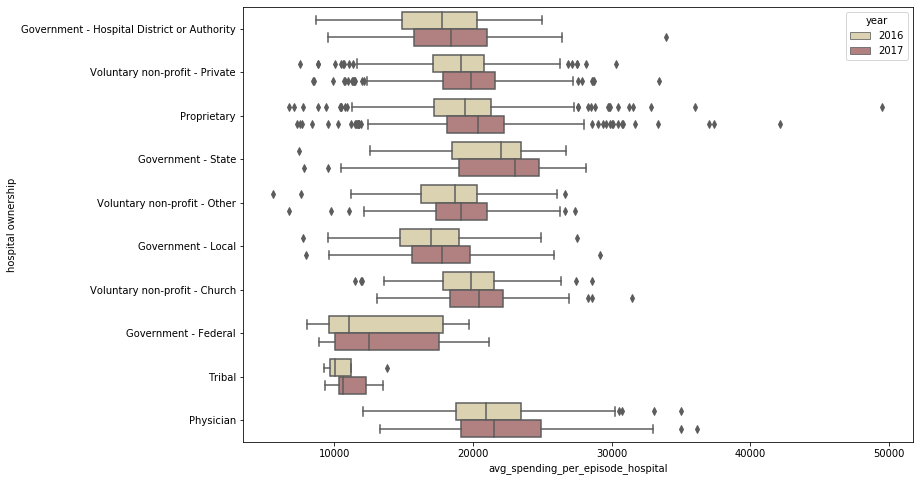

In [304]:
#Assess overall mean average spending per episode by five-star-rating and then broken down by hospital ownership. 
#What do you observe?
combined_spending_and_hosp_related['hospital ownership'].value_counts()
plt.figure(figsize=(12,8))
ax = sns.boxplot(y='hospital ownership', x='avg_spending_per_episode_hospital', 
                     hue="year",data=combined_spending_and_hosp_related, palette="pink_r")

In [336]:
#add difference column to main dataframe
combined_spending_and_hosp_related['state_diff from natl avg'] = combined_spending_and_hosp_related['avg_spending_per_episode_state'] - combined_spending_and_hosp_related['avg_spending_per_episode_nation']
combined_spending_and_hosp_related['ep hosp difference from natl avg'] =combined_spending_and_hosp_related['avg_spending_per_episode_state'] - combined_spending_and_hosp_related['avg_spending_per_episode_nation']
combined_spending_and_hosp_related.head()

,provider_id,hospital name,address,city,state,zip code,county name,phone number,hospital type,hospital ownership,emergency services,meets criteria for meaningful use of ehrs,hospital overall rating,mortality national comparison,safety of care national comparison,readmission national comparison,patient experience national comparison,effectiveness of care national comparison,timeliness of care national comparison,efficient use of medical imaging national comparison,year,hospital_name,period,claim_type,avg_spending_per_episode_hospital,avg_spending_per_episode_state,avg_spending_per_episode_nation,state_diff from natl avg,ep hosp difference from natl avg
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,HOUSTON,3.347939e+09,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,Same as the national average,Above the national average,Below the national average,Below the national average,Same as the national average,Same as the national average,Same as the national average,2016,SOUTHEAST ALABAMA MEDICAL CENTER,Complete Episode,Total,20711.0,19139.0,20302.0,-1163.0,-1163.0
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957.0,MARSHALL,2.565938e+09,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,Below the national average,Same as the national average,Above the national average,Same as the national average,Same as the national average,Above the national average,Below the national average,2016,MARSHALL MEDICAL CENTERS,Complete Episode,Total,16849.0,19139.0,20302.0,-1163.0,-1163.0
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631.0,LAUDERDALE,2.567688e+09,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,Below the national average,Same as the national average,Below the national average,Below the national average,Same as the national average,Above the national average,Below the national average,2016,ELIZA COFFEE MEMORIAL HOSPITAL,Complete Episode,Total,19553.0,19139.0,20302.0,-1163.0,-1163.0
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467.0,COVINGTON,3.344934e+09,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2,Below the national average,Not Available,Below the national average,Same as the national average,Below the national average,Above the national average,Not Available,2016,MIZELL MEMORIAL HOSPITAL,Complete Episode,Total,15899.0,19139.0,20302.0,-1163.0,-1163.0
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049.0,CRENSHAW,3.343353e+09,Acute Care Hospitals,Proprietary,Yes,Y,4,Not Available,Not Available,Above the national average,Not Available,Same as the national average,Above the national average,Not Available,2016,CRENSHAW COMMUNITY HOSPITAL,Complete Episode,Total,12254.0,19139.0,20302.0,-1163.0,-1163.0


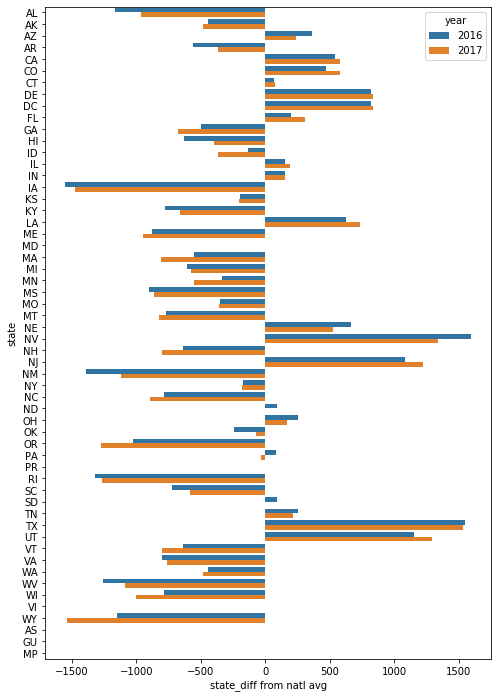

In [341]:
#plot difference from national average by state
plt.figure(figsize=(8,12))
ax = sns.barplot(y="state", x="state_diff from natl avg",hue='year', data=combined_spending_and_hosp_related)